In [100]:
from socceraction.data.wyscout import PublicWyscoutLoader
from socceraction.spadl.wyscout import convert_to_actions
from socceraction.data.opta import OptaLoader
from socceraction.data.statsbomb import StatsBombLoader
from socceraction.spadl.config import actiontypes, bodyparts
import socceraction.spadl as spadl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error
from xgboost import XGBClassifier, XGBRegressor
import math
import pickle
from mplsoccer import Pitch

In [101]:
COLUMNS_XPASS_MODEL = ["timestamp", "player_id_src", "player_id_target", "start_x", "start_y", "end_x", "end_y", "bodypart_id", "distance_pass", "is_home_team"]
COLUMNS_XGOAL_MODEL = ["timestamp", "player_id", "distance_to_goal", "angle_to_goal", "is_home_team", "bodypart_id"]
STANDARD_LENGTH_COURT = 105
STANDARD_WIDTH_COURT = 68
STANDARD_GOALLINE_WIDTH = 7.32

# Load Model from External Directory
def load_model_from_external_file_pickle(filename_path):
    return pickle.load(open(filename_path, 'rb'))

# Create Dataframe from Raw Input Coordinate Player
def load_df_raw_input_coordinate_player(filename_path):
    return pd.read_csv(filename_path, delimiter=";")

# Helper to calculate distance pass
def calculate_distance_pass(coordinate_x, coordinate_y, end_x, end_y):
    distance_passing = math.sqrt((abs(end_x - coordinate_x)) ** 2 + (abs(end_y - coordinate_y)) ** 2)
    return distance_passing

# Helper to calculate distance to opponent's goal
def calculate_distance_to_goal(length_court, width_court, coordinate_x, coordinate_y, is_home_team):
    if is_home_team:
        distance_to_goal = math.sqrt((abs(length_court - coordinate_x)) ** 2 + (abs((0.5 * width_court) - coordinate_y)) ** 2)
    else:
        distance_to_goal = math.sqrt((coordinate_x) ** 2 + (abs((0.5 * width_court) - coordinate_y)) ** 2)
    return distance_to_goal

# Helper to calculate angle to opponent's goal
def calculate_angle_to_goal(goalline_width, length_court, width_court, coordinate_x, coordinate_y, is_home_team):
    if is_home_team:
        L = abs(length_court - coordinate_x)
    else:
        L = coordinate_x
    W = abs((0.5 * width_court) - coordinate_y)
    return math.atan((goalline_width * L) / (L ** 2 + W ** 2 - (goalline_width / 2) ** 2))

# Construct xpass dataset from input csv decision making model
def construct_xpass_dataset_from_df_raw_input(df_raw_input):
    unique_timestamps = sorted(df_raw_input['timestamp'].unique())
    empty_xpass_df = pd.DataFrame(columns=COLUMNS_XPASS_MODEL, index=[0])

    for timestamp in unique_timestamps:
        df_raw_this_timestamp = df_raw_input[df_raw_input['timestamp'] == timestamp]
        unique_id_players_this_timestamp = df_raw_this_timestamp['player_id'].unique()
        for player_id_source in unique_id_players_this_timestamp:
            for player_id_target in unique_id_players_this_timestamp:
                if player_id_source == player_id_target:
                    continue
                # Select Features
                start_x = df_raw_this_timestamp.loc[df_raw_this_timestamp["player_id"] == player_id_source, "coordinate_x"].iloc[0]
                start_y = df_raw_this_timestamp.loc[df_raw_this_timestamp["player_id"] == player_id_source, "coordinate_y"].iloc[0]
                end_x = df_raw_this_timestamp.loc[df_raw_this_timestamp["player_id"] == player_id_target, "coordinate_x"].iloc[0]
                end_y = df_raw_this_timestamp.loc[df_raw_this_timestamp["player_id"] == player_id_target, "coordinate_y"].iloc[0]
                is_home_team = 1 if (df_raw_this_timestamp.loc[df_raw_this_timestamp["player_id"] == player_id_source, "is_opponent_team"].iloc[0] == 0) else 0
                # Bodypart ID is assumed to be foot (id = 0) for now
                bodypart_id = 0
                distance_pass = calculate_distance_pass(start_x, start_y, end_x, end_y)
                # Append new row to (empty) xpass dataframe
                new_row = pd.DataFrame({"timestamp": timestamp, "player_id_src": player_id_source, "player_id_target": player_id_target, 
                           "start_x": start_x, "start_y": start_y, "end_x": end_x, "end_y": end_y, 
                           "bodypart_id": bodypart_id, "distance_pass": distance_pass, "is_home_team": is_home_team}, index=[0])
                empty_xpass_df = pd.concat([new_row, empty_xpass_df.loc[:]]).reset_index(drop=True)

    return empty_xpass_df

# Construct xgoal dataset from input csv decision making model
def construct_xgoal_dataset_from_df_raw_input(df_raw_input):
    unique_timestamps = sorted(df_raw_input['timestamp'].unique())
    empty_xgoal_df = pd.DataFrame(columns=COLUMNS_XGOAL_MODEL, index=[0])

    for timestamp in unique_timestamps:
        df_raw_this_timestamp = df_raw_input[df_raw_input['timestamp'] == timestamp]
        unique_id_players_this_timestamp = df_raw_this_timestamp['player_id'].unique()
        for player_id in unique_id_players_this_timestamp:
            # Select Features
            start_x = df_raw_this_timestamp.loc[df_raw_this_timestamp["player_id"] == player_id, "coordinate_x"].iloc[0]
            start_y = df_raw_this_timestamp.loc[df_raw_this_timestamp["player_id"] == player_id, "coordinate_y"].iloc[0]
            is_home_team = 1 if (df_raw_this_timestamp.loc[df_raw_this_timestamp["player_id"] == player_id, "is_opponent_team"].iloc[0] == 0) else 0
            # Bodypart ID is assumed to be foot (id = 0) for now
            bodypart_id = 0
            distance_to_goal = calculate_distance_to_goal(STANDARD_LENGTH_COURT, STANDARD_WIDTH_COURT, start_x, start_y, is_home_team)
            angle_to_goal = calculate_angle_to_goal(STANDARD_GOALLINE_WIDTH, STANDARD_LENGTH_COURT, STANDARD_WIDTH_COURT, start_x, start_y, is_home_team)
            # Append new row to (empty) xpass dataframe
            new_row = pd.DataFrame({"timestamp": timestamp, "player_id": player_id, "distance_to_goal": distance_to_goal, "angle_to_goal": angle_to_goal, "is_home_team": is_home_team, "bodypart_id": bodypart_id}, index=[0])
            empty_xgoal_df = pd.concat([new_row, empty_xgoal_df.loc[:]]).reset_index(drop=True)

    return empty_xgoal_df

In [102]:
INPUT_RAW_PLAYER_COORDINATE_FILEPATH = "data/input_decision_making_model/input_coordinate_player_csv.csv"

raw_input_coordinate_player_df = load_df_raw_input_coordinate_player(INPUT_RAW_PLAYER_COORDINATE_FILEPATH)

In [103]:
# FINAL XPASS DATAFRAME
xpass_dataframes_test = construct_xpass_dataset_from_df_raw_input(raw_input_coordinate_player_df)
xpass_dataframes_test.dropna(inplace=True)
xpass_dataframes_test

,timestamp,player_id_src,player_id_target,start_x,start_y,end_x,end_y,bodypart_id,distance_pass,is_home_team
0,1,6,5,39.375,21.25,39.375,46.75,0,25.500000,1
1,1,6,4,39.375,21.25,83.125,55.25,0,55.408145,1
2,1,6,3,39.375,21.25,83.125,12.75,0,44.568066,1
3,1,6,2,39.375,21.25,65.625,21.25,0,26.250000,1
4,1,6,1,39.375,21.25,65.625,46.75,0,36.596619,1
5,1,5,6,39.375,46.75,39.375,21.25,0,25.500000,1
6,1,5,4,39.375,46.75,83.125,55.25,0,44.568066,1
7,1,5,3,39.375,46.75,83.125,12.75,0,55.408145,1
8,1,5,2,39.375,46.75,65.625,21.25,0,36.596619,1
9,1,5,1,39.375,46.75,65.625,46.75,0,26.250000,1


In [104]:
# FINAL XGOAL DATAFRAME
xgoal_dataframes_test = construct_xgoal_dataset_from_df_raw_input(raw_input_coordinate_player_df)
xgoal_dataframes_test.dropna(inplace=True)
xgoal_dataframes_test

,timestamp,player_id,distance_to_goal,angle_to_goal,is_home_team,bodypart_id
0,1,6,66.852099,0.107394,1,0
1,1,5,66.852099,0.107394,1,0
2,1,4,30.497182,0.172934,1,0
3,1,3,30.497182,0.172934,1,0
4,1,2,41.387838,0.167990,1,0
5,1,1,41.387838,0.167990,1,0


In [105]:
# FUNCTION TO PREPROCESS FINAL XPASS DATAFRAME
def preprocess_xpass_test(xpass_df):
    # 1. Change start_x, start_y, end_x, end_y with StandardScaler
    scaler = preprocessing.StandardScaler()
    columns = ["start_x", "start_y", "end_x", "end_y", "distance_pass"]
    xpass_df[columns] = scaler.fit_transform(xpass_df[columns])

    # 2. Change incorrect type of bodypart_id and is_home_team columns
    xpass_df['bodypart_id'] = xpass_df['bodypart_id'].astype("int64")
    xpass_df['is_home_team'] = xpass_df['is_home_team'].astype("int64")

    return xpass_df

# VERIFY XPASS PROBABILITY BASED ON MODEL
filename = "xgbRegressor_xpass_model.sav"
directory_model = "data/model_xpass_wyscout/"
xpass_model = pickle.load(open(directory_model + filename, 'rb'))

xpass_dataframes_test_verify = xpass_dataframes_test.copy(deep=True)
xpass_dataframes_test_verify = preprocess_xpass_test(xpass_dataframes_test_verify)
featured_column_based_on_model = ["start_x", "start_y", "end_x", "end_y", "bodypart_id", "distance_pass", "is_home_team"]
X_test = xpass_dataframes_test_verify[featured_column_based_on_model]
y_verify_result = xpass_model.predict(X_test)

xpass_dataframes_test['probability_score'] = y_verify_result
xpass_dataframes_test

,timestamp,player_id_src,player_id_target,start_x,start_y,end_x,end_y,bodypart_id,distance_pass,is_home_team,probability_score
0,1,6,5,39.375,21.25,39.375,46.75,0,25.500000,1,0.880763
1,1,6,4,39.375,21.25,83.125,55.25,0,55.408145,1,0.577694
2,1,6,3,39.375,21.25,83.125,12.75,0,44.568066,1,0.660237
3,1,6,2,39.375,21.25,65.625,21.25,0,26.250000,1,0.680448
4,1,6,1,39.375,21.25,65.625,46.75,0,36.596619,1,0.725533
5,1,5,6,39.375,46.75,39.375,21.25,0,25.500000,1,0.872248
6,1,5,4,39.375,46.75,83.125,55.25,0,44.568066,1,0.540123
7,1,5,3,39.375,46.75,83.125,12.75,0,55.408145,1,0.586785
8,1,5,2,39.375,46.75,65.625,21.25,0,36.596619,1,0.730475
9,1,5,1,39.375,46.75,65.625,46.75,0,26.250000,1,0.697112


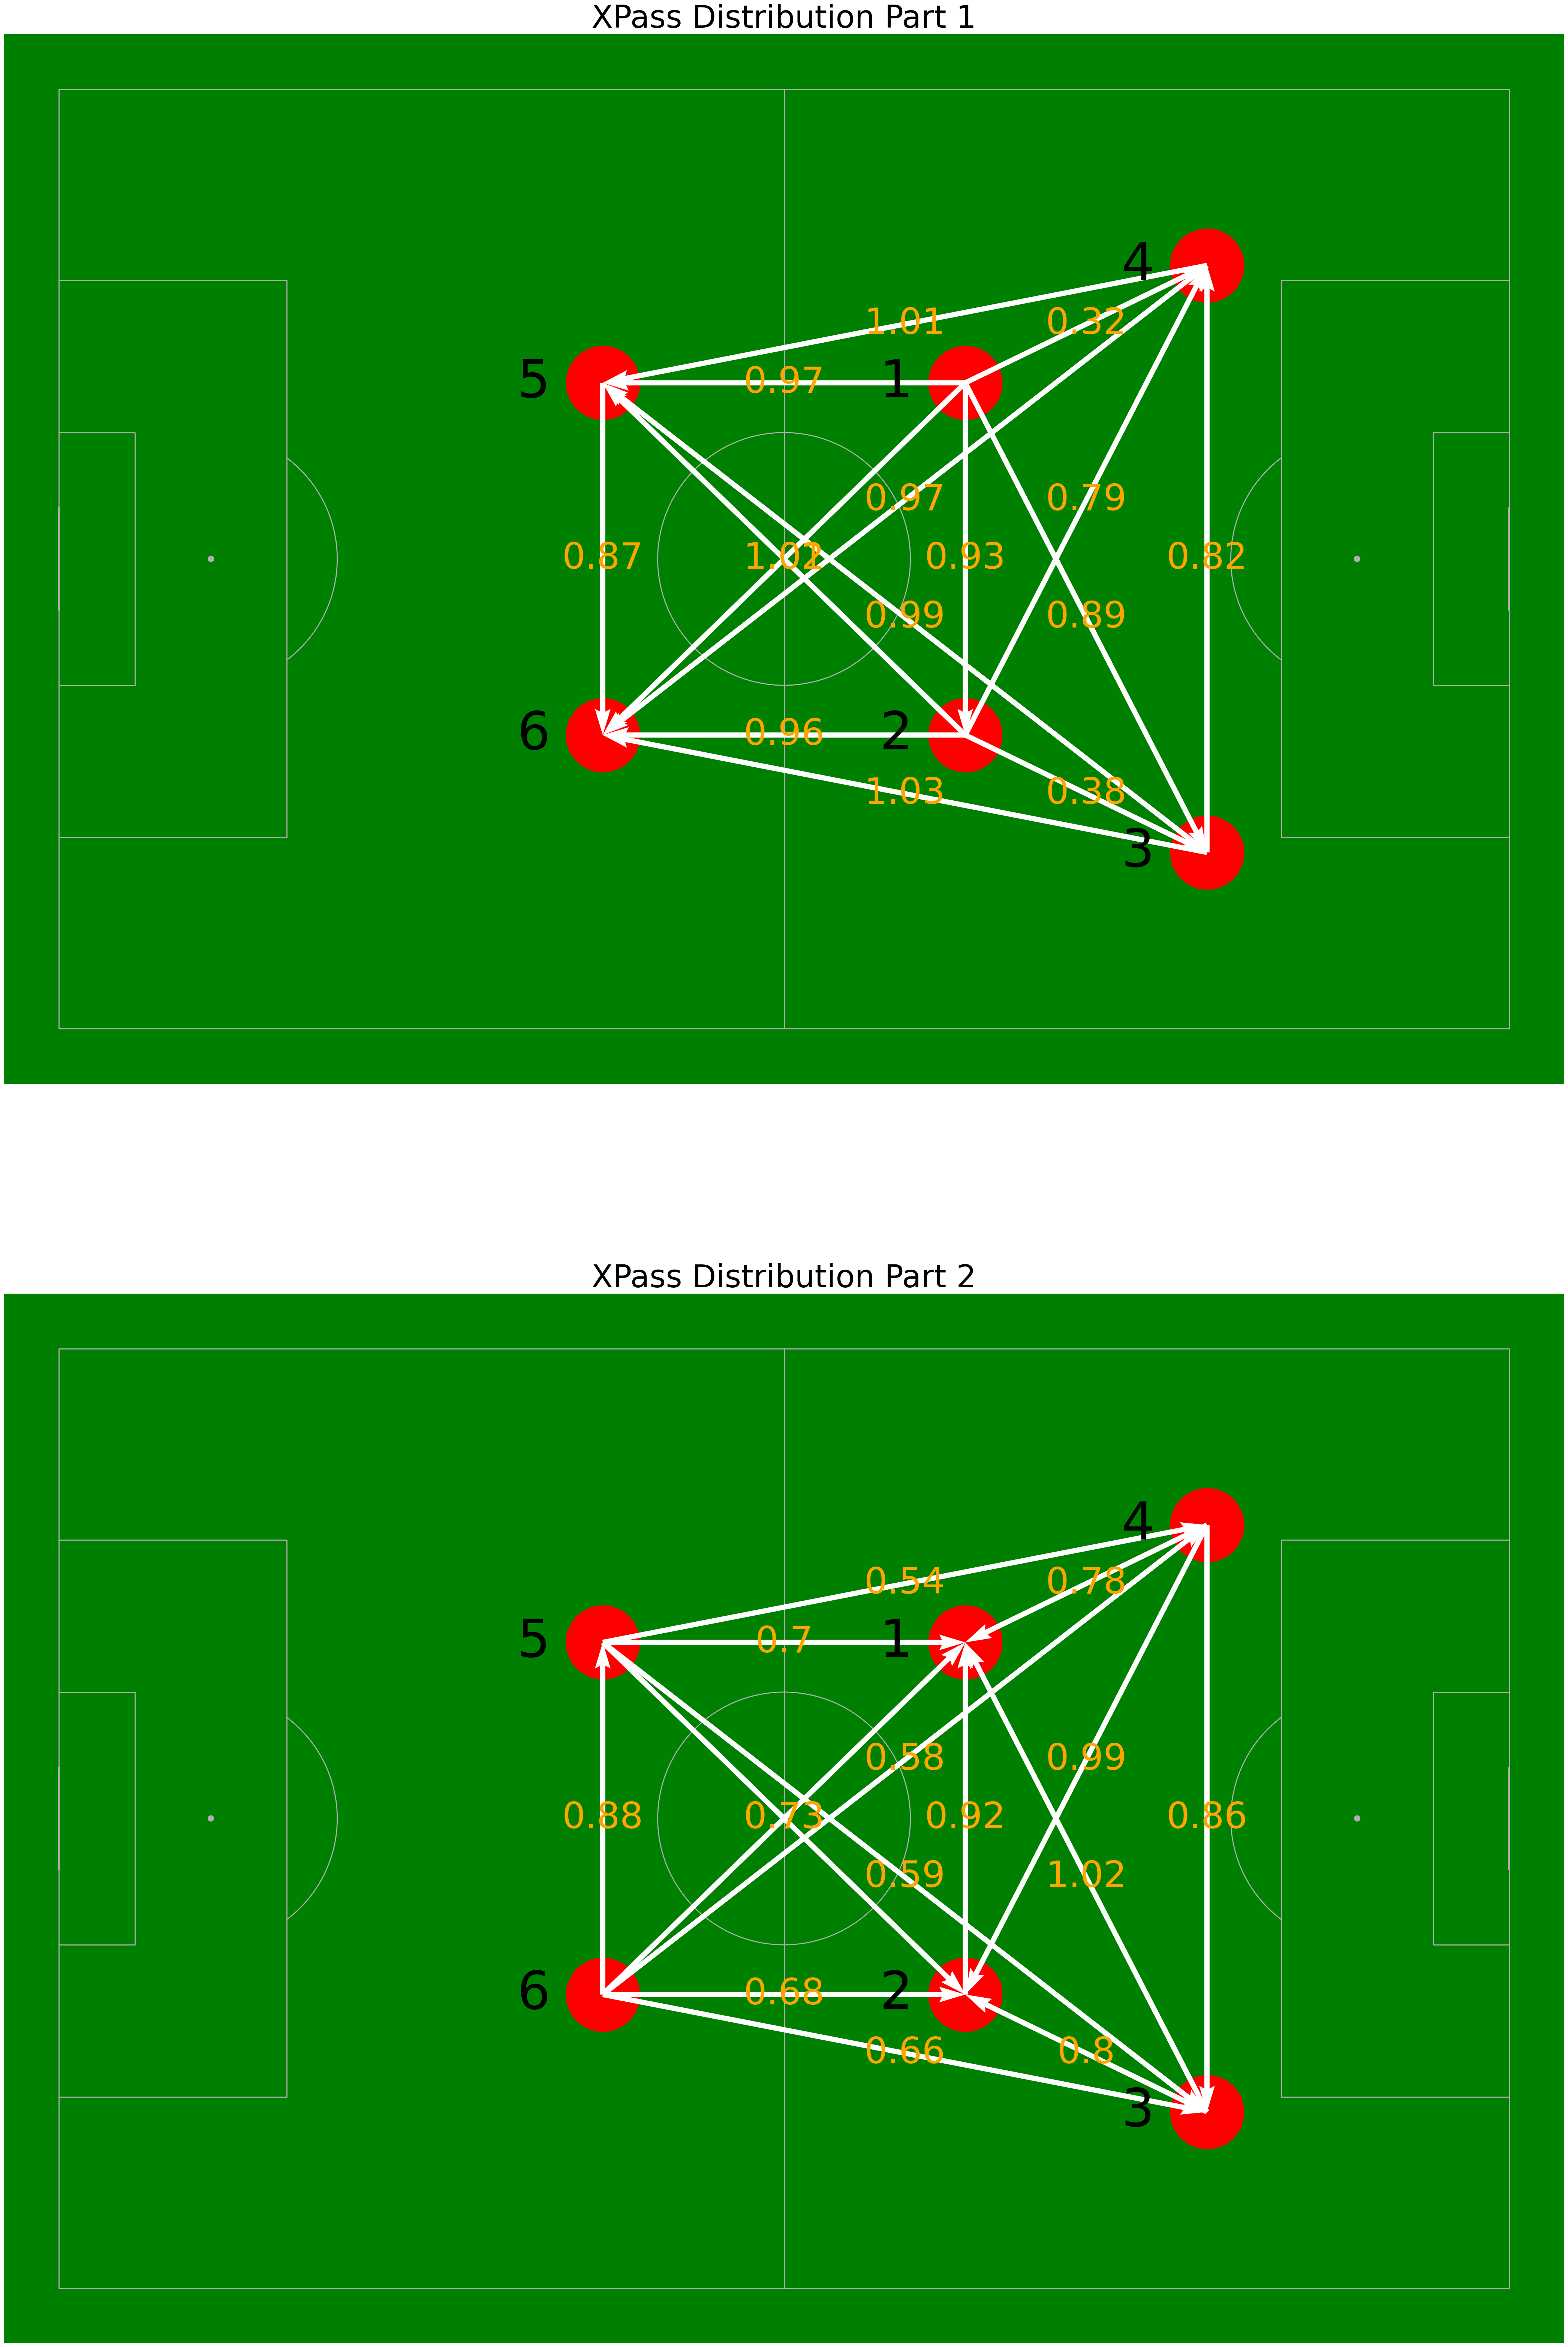

In [106]:
# PLOT PASS PROBABILITY INTO PITCH IMAGE
def plot_passing_probability_network(raw_input_from_csv, xpass_final_df):
    fig, axs = plt.subplots(2,1)
    fig.set_figheight(80)
    fig.set_figwidth(100)
    pitchXPass_part1 = Pitch(pitch_type="custom", pitch_length=105, pitch_width=68, pitch_color="green")
    pitchXPass_part1.draw(axs[0], figsize=(200,100), constrained_layout=True, tight_layout=False)
    axs[0].set_title("XPass Distribution Part 1", fontsize=60)
    pitchXPass_part2 = Pitch(pitch_type="custom", pitch_length=105, pitch_width=68, pitch_color="green")
    pitchXPass_part2.draw(axs[1], figsize=(200,100), constrained_layout=True, tight_layout=False)
    axs[1].set_title("XPass Distribution Part 2", fontsize=60)

    timestamps_sorted = sorted(raw_input_from_csv['timestamp'].unique())
    for timestamp in timestamps_sorted:
        raw_input_this_timestamp = raw_input_from_csv[raw_input_from_csv['timestamp'] == timestamp]
        unique_player_ids_this_timestamp = raw_input_this_timestamp['player_id'].unique()

        for player_id in unique_player_ids_this_timestamp:
            start_x = raw_input_this_timestamp.loc[raw_input_this_timestamp["player_id"] == player_id, "coordinate_x"].iloc[0]
            start_y = raw_input_this_timestamp.loc[raw_input_this_timestamp["player_id"] == player_id, "coordinate_y"].iloc[0]
            idx_column = 0
            for pitch in [pitchXPass_part1, pitchXPass_part2]:
                pitch.scatter(x=start_x, y=start_y, color="red", ax=axs[idx_column], s=20000)
                axs[idx_column].annotate(text=player_id, xy=(start_x - 5, start_y), ha="center", va="center", size=100)
                idx_column += 1

        list_unique_arrows = []
        for player_id_src in unique_player_ids_this_timestamp:
            for player_id_target in unique_player_ids_this_timestamp:
                if player_id_src == player_id_target:
                    continue
                if ((player_id_src, player_id_target) not in list_unique_arrows) and ((player_id_target, player_id_src) not in list_unique_arrows):
                    list_unique_arrows.append((player_id_src, player_id_target))
                    pitch = pitchXPass_part1
                    idx_column = 0
                else:
                    pitch = pitchXPass_part2
                    idx_column = 1
                specific_row_xpass_df = xpass_final_df.loc[(xpass_final_df["player_id_src"] == player_id_src) & (xpass_final_df["player_id_target"] == player_id_target), ["start_x", "start_y", "end_x", "end_y", "probability_score"]].iloc[0]
                pitch.arrows(xstart=specific_row_xpass_df["start_x"], ystart=specific_row_xpass_df["start_y"], xend=specific_row_xpass_df["end_x"], yend=specific_row_xpass_df["end_y"], ax=axs[idx_column], color="white", width=10)
                x_line = (specific_row_xpass_df["end_x"] + specific_row_xpass_df["start_x"]) / 2
                y_line = (specific_row_xpass_df["end_y"] + specific_row_xpass_df["start_y"]) / 2   
                axs[idx_column].annotate(text=str(round(specific_row_xpass_df["probability_score"], 2)), xy=(x_line, y_line), ha="center", va="center", size=70, color="orange")
    
    plt.show()

plot_passing_probability_network(raw_input_coordinate_player_df, xpass_dataframes_test)

In [107]:
# FUNCTION TO PREPROCESS FINAL XGOAL DATAFRAME
def preprocess_xgoal_test(xgoal_df):
    # 1. Change start_x, start_y, end_x, end_y with StandardScaler
    scaler = preprocessing.StandardScaler()
    columns = ["distance_to_goal", "angle_to_goal"]
    xgoal_df[columns] = scaler.fit_transform(xgoal_df[columns])

    # 2. Change incorrect type of bodypart_id and is_home_team columns
    xgoal_df['bodypart_id'] = xgoal_df['bodypart_id'].astype("int64")
    xgoal_df['is_home_team'] = xgoal_df['is_home_team'].astype("int64")

    return xgoal_df

# VERIFY XGOAL PROBABILITY BASED ON MODEL
filename = "xgbRegressor_xgoal_model.sav"
directory_model = "data/model_xgoal_wyscout/"
xgoal_model = pickle.load(open(directory_model + filename, 'rb'))

xgoal_dataframes_test_verify = xgoal_dataframes_test.copy(deep=True)
xgoal_dataframes_test_verify = preprocess_xgoal_test(xgoal_dataframes_test_verify)
featured_column_based_on_model = ["distance_to_goal", "angle_to_goal", "is_home_team", "bodypart_id"]
X_test = xgoal_dataframes_test_verify[featured_column_based_on_model]
y_verify_result = xgoal_model.predict(X_test)

xgoal_dataframes_test['probability_score'] = y_verify_result
xgoal_dataframes_test

,timestamp,player_id,distance_to_goal,angle_to_goal,is_home_team,bodypart_id,probability_score
0,1,6,66.852099,0.107394,1,0,0.111611
1,1,5,66.852099,0.107394,1,0,0.111611
2,1,4,30.497182,0.172934,1,0,0.060612
3,1,3,30.497182,0.172934,1,0,0.060612
4,1,2,41.387838,0.167990,1,0,0.334419
5,1,1,41.387838,0.167990,1,0,0.334419


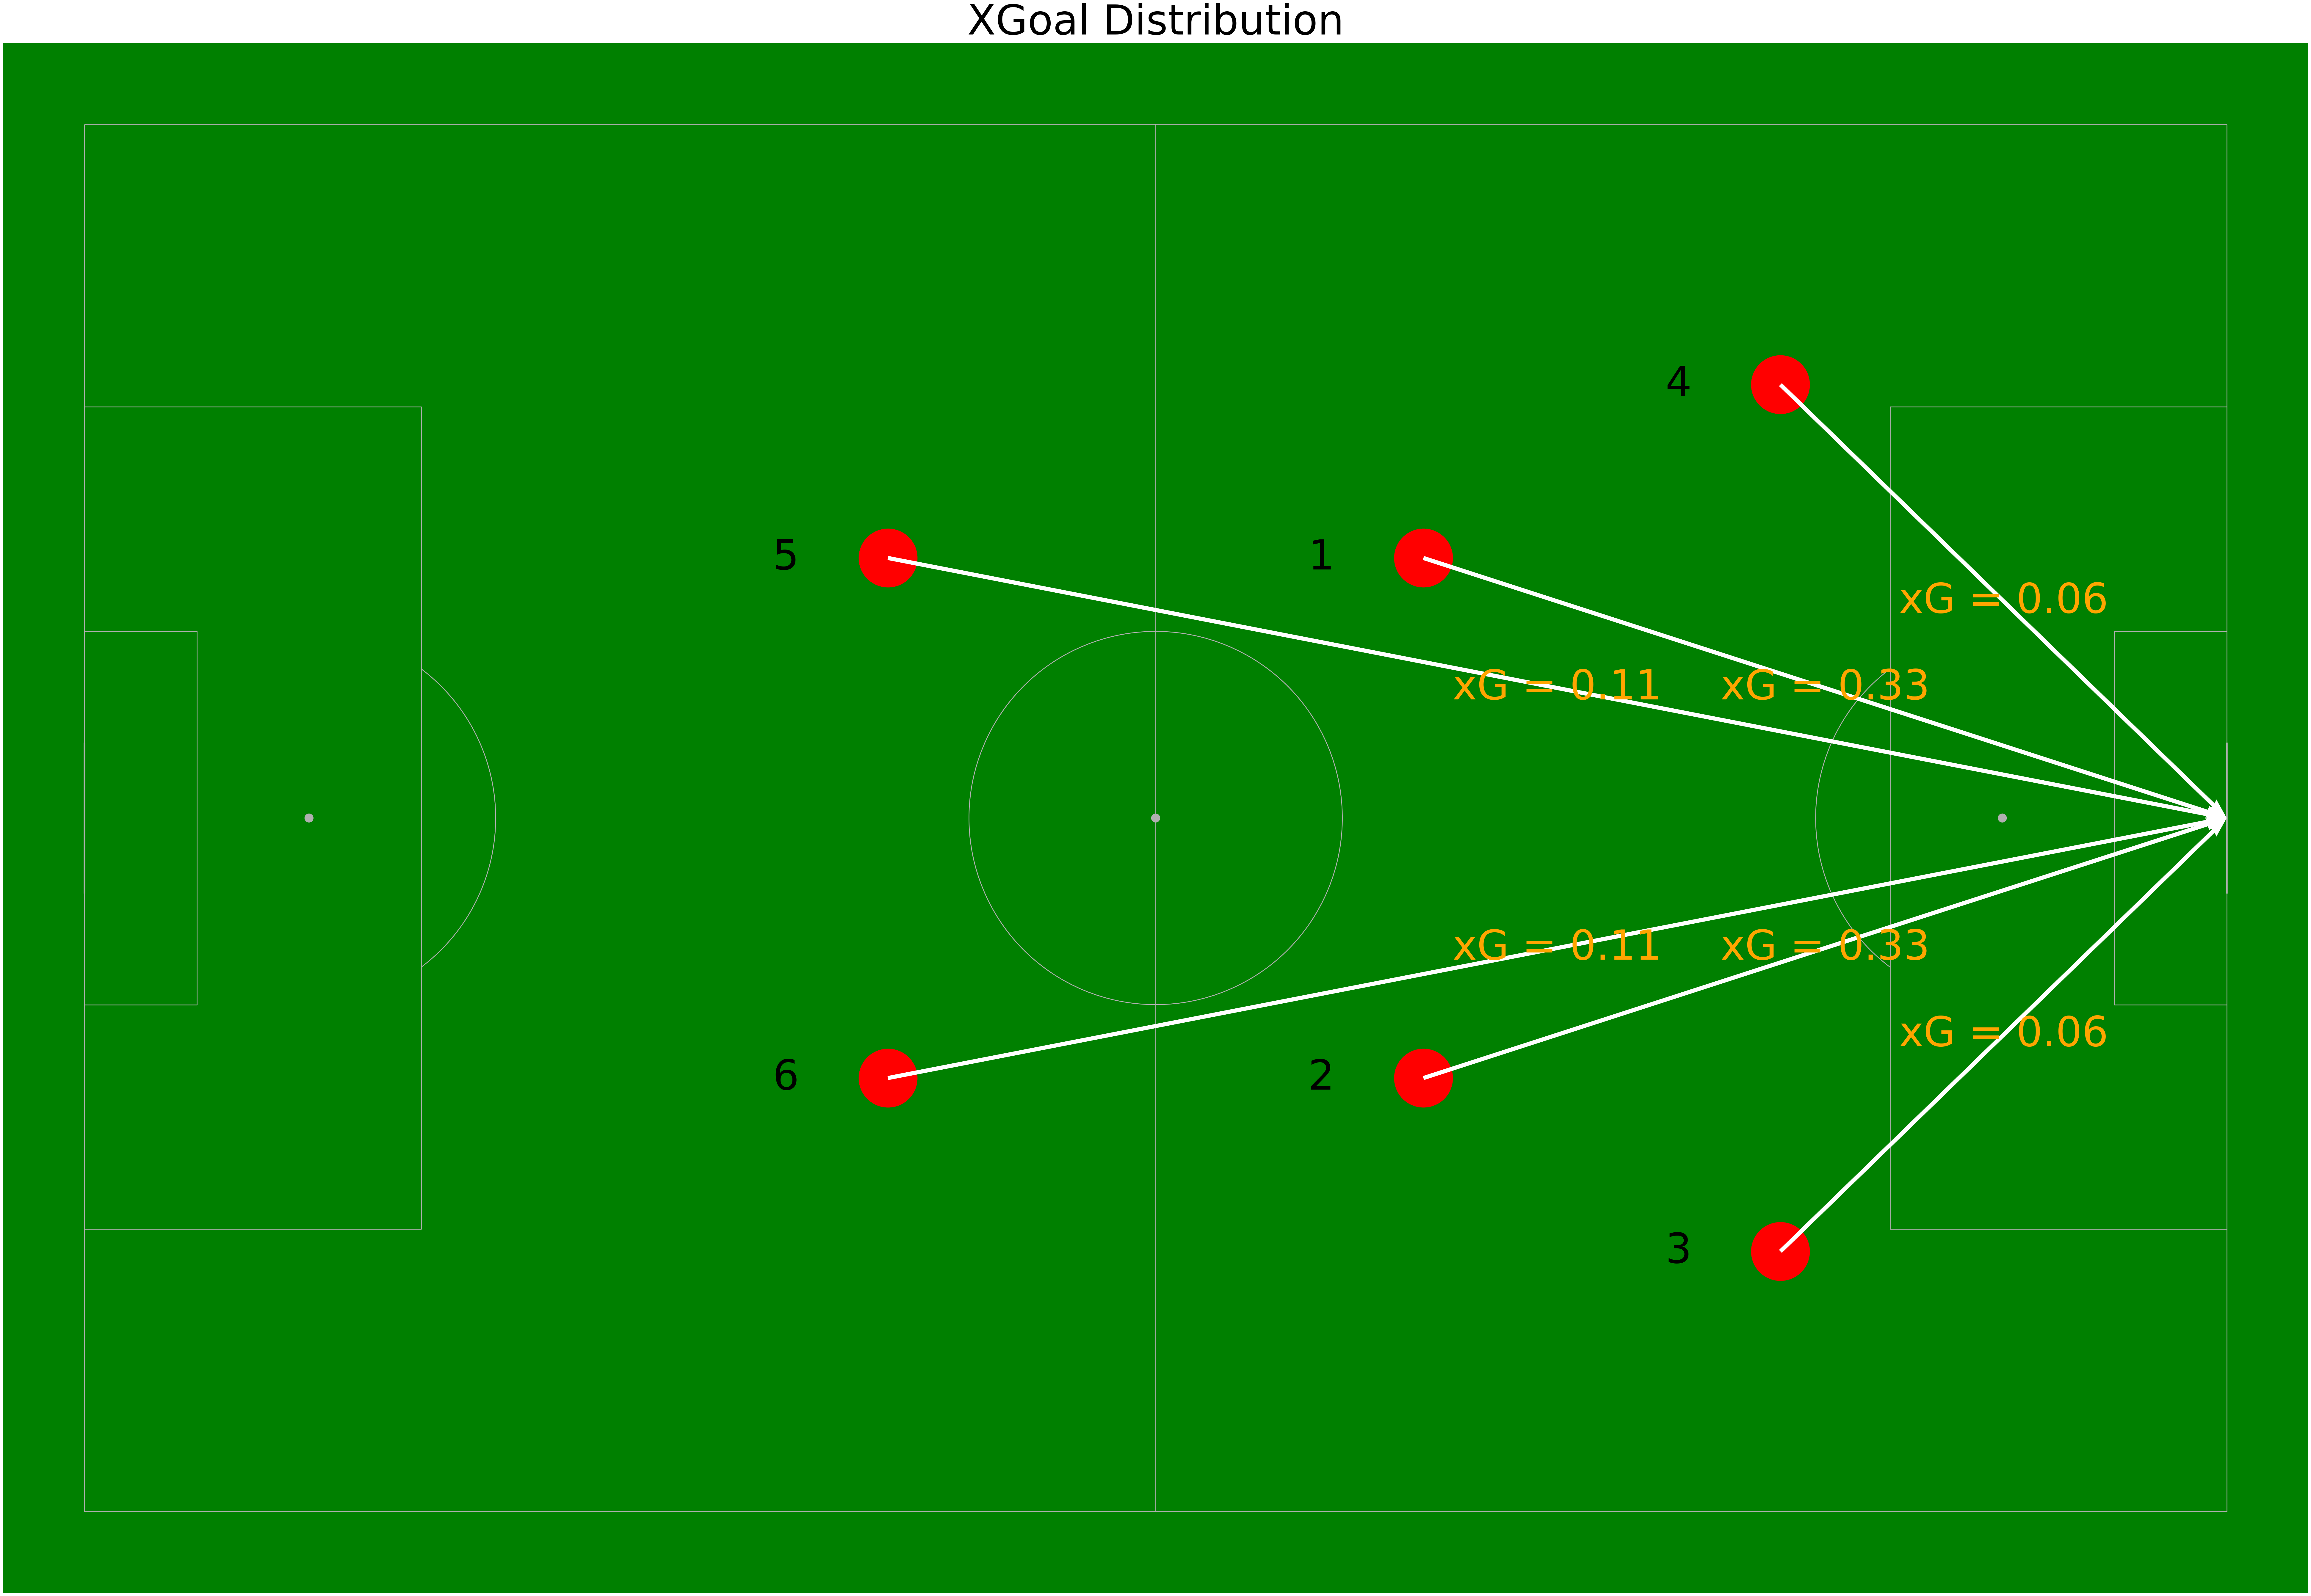

In [108]:
# PLOT GOAL PROBABILITY INTO PITCH IMAGE
def plot_goal_probability_network(raw_input_from_csv, xgoal_final_df):
    pitchXGoal = Pitch(pitch_type="custom", pitch_length=105, pitch_width=68, pitch_color="green")
    fig, ax = pitchXGoal.draw(figsize=(100,80), constrained_layout=True, tight_layout=False)
    ax.set_title("XGoal Distribution", fontsize=100)

    timestamps_sorted = sorted(raw_input_from_csv['timestamp'].unique())
    for timestamp in timestamps_sorted:
        raw_input_this_timestamp = raw_input_from_csv[raw_input_from_csv['timestamp'] == timestamp]
        unique_player_ids_this_timestamp = raw_input_this_timestamp['player_id'].unique()

        for player_id in unique_player_ids_this_timestamp:
            start_x = raw_input_this_timestamp.loc[raw_input_this_timestamp["player_id"] == player_id, "coordinate_x"].iloc[0]
            start_y = raw_input_this_timestamp.loc[raw_input_this_timestamp["player_id"] == player_id, "coordinate_y"].iloc[0]
            pitchXGoal.scatter(x=start_x, y=start_y, color="red", ax=ax, s=20000)
            ax.annotate(text=player_id, xy=(start_x - 5, start_y), ha="center", va="center", size=100)

        for player_id in unique_player_ids_this_timestamp:
            specific_row_xgoal_df = xgoal_final_df.loc[xgoal_final_df["player_id"] == player_id, ["is_home_team", "probability_score"]].iloc[0]
            start_x = raw_input_this_timestamp.loc[raw_input_this_timestamp["player_id"] == player_id, "coordinate_x"].iloc[0]
            start_y = raw_input_this_timestamp.loc[raw_input_this_timestamp["player_id"] == player_id, "coordinate_y"].iloc[0]
            end_x = 105 if (specific_row_xgoal_df['is_home_team'] == 1) else 0
            end_y = 34

            pitchXGoal.arrows(xstart=start_x, ystart=start_y, xend=end_x, yend=end_y, ax=ax, color="white", width=10)
            x_line = (end_x + start_x) / 2
            y_line = (end_y + start_y) / 2   
            ax.annotate(text=("xG = " + str(round(specific_row_xgoal_df["probability_score"], 2))), xy=(x_line, y_line), ha="center", va="center", size=100, color="orange")
    
    plt.show()

plot_goal_probability_network(raw_input_coordinate_player_df, xgoal_dataframes_test)